<a href="https://colab.research.google.com/github/ds4ph-bme/project-6-HerambGupta/blob/main/punk_tumor_adder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# OH NO

A virus is coming where 50% of the cryptopunks will have contracted a disease where they get a white spot. The code below generates the disease. Your job is as follows

1. Generate the data as below
2. Train a convolutional neural network to classify punks as diseased or not
   1. Creat a testing and validation set. Contrast in the in sample and out of sample errors.
   2. Visualize some of your errors (in both directions) and describe what is happening.
   3. Create a python function that takes in an np image array just like the cancerpunks one below and gives probabilities that that punk has this disease.

In [168]:

import urllib.request
import PIL
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, losses

## Open the image
imgURL = "https://raw.githubusercontent.com/larvalabs/cryptopunks/master/punks.png"
urllib.request.urlretrieve(imgURL, "cryptoPunksAll.jpg")
img = PIL.Image.open("cryptoPunksAll.jpg").convert("RGB")
imgArray = np.asarray(img)

n = 10000

finalArray = np.empty((n, 24, 24, 3))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    finalArray[idx,:,:,:] = imgArray[a:b,c:d,:]


Our doctors have determined this is the region where the lesion occurs.

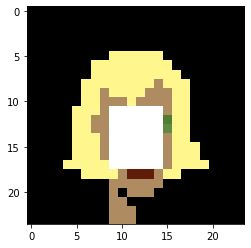

In [169]:

temp  =  finalArray[0,:,:,:].copy()

d2min, d2max = 9,14 
d1min, d1max = 11,17

temp[d1min : (d1max + 1), d2min : (d2max + 1)] = 255

plt.imshow(temp.astype('uint8'))



In [170]:
cancerpunks = finalArray.copy()
label = np.zeros(n)

## Loop over the cryptopunks
for i in range(10000):
  flip = np.random.randint(0, 2)
  if flip is 1:
    label[i] = 1
    d1loc = np.random.randint(d1min, d1max + 1)
    d2loc = np.random.randint(d2min, d2max + 1)
    cancerpunks[i,d1loc,d2loc,:] = 255



(10000, 24, 24, 3)


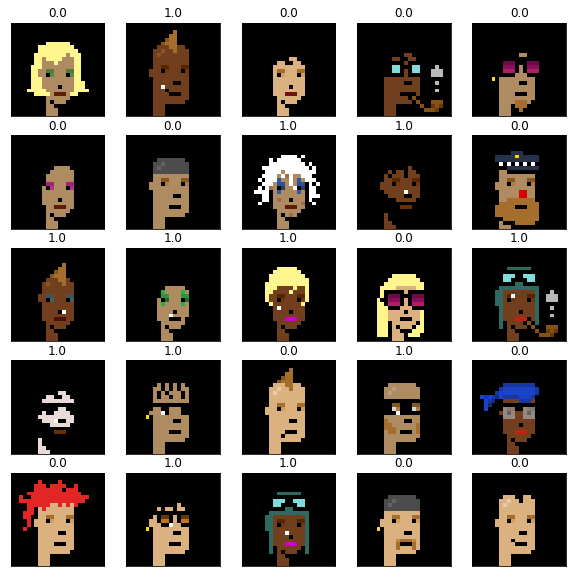

In [171]:
## plot some examples
plt.figure(figsize=(10,10))
for i in range(25): 
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(cancerpunks[i,:,:,:].astype('uint8'))
  plt.title(label[i])

print(cancerpunks.shape)

In [172]:
arr=np.empty((2400,2400,3))

for i in range(100):
  for j in range(100):
    a,b =24*i,24* (i+1)
    c,d =24*j,24* (j+1)
    idx=j+i *(100)
    arr[a:b,c:d,:]=cancerpunks[idx,:,:,:]

final = np.empty((10000, 3, 24, 24))
for i in range(100):
  for j in range(100):
    a, b = 24 * i, 24 * (i + 1)  
    c, d = 24 * j, 24 * (j + 1) 
    idx = j + i * (100)
    final[idx,0,:,:] = arr[a:b,c:d,0]
    final[idx,1,:,:] = arr[a:b,c:d,1]
    final[idx,2,:,:] = arr[a:b,c:d,2]

n = final.shape[0]
trainFraction = .75
sample = np.random.uniform(size = n) < trainFraction
x_train = final[ sample, :, :, :] / 255
x_test =  final[~sample, :, :, :] / 255
print([x_train.shape, x_test.shape])

y_train = label[sample]
y_test =  label[~sample]

## Need to have the extra dimension
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

[(7426, 3, 24, 24), (2574, 3, 24, 24)]


In [173]:
import torch 
torch.manual_seed(10)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms

trainDataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size = 100, shuffle = False, num_workers = 1)

In [174]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        ## This has to be changed because the size
        ## of our inputs is different than the CFAR
        ## example. There's is 32x32 and ours is 24x24
        ## Also, I changed the rest of the network architecture
        ## here
        ## Finally, we only have one output.
        self.fc1 = nn.Linear(16 * 3 * 3, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x
net = Net()

In [175]:
import torch.optim as optim
#criterion = nn.CrossEntropyLoss()
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9)

In [176]:
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [177]:
insample = net(torch.Tensor(x_train)).detach().numpy()
outsample= net(torch.Tensor(x_test)).detach().numpy()
in_y_label=np.zeros(len(insample))
out_y_label= np.zeros(len(outsample))

In [178]:
in_l=len(insample)
out_l=len(outsample)
for i in range(in_l):
  if insample[i]>0.5:
    in_y_label[i]=1

for j in range(out_l):
  if outsample[j]>0.5:
    out_y_label[j]=1

in_acc=np.mean(in_y_label==y_train)
out_acc=np.mean(out_y_label==y_test)

print('Insample Accuracy is ',in_acc)
print('Outsample Accuracy is',out_acc)

Insample Accuracy is  0.5011823272683329
Outsample Accuracy is 0.49604254849010093


In [179]:
x_train_new=cancerpunks[sample,:,:,:]
x_test_new=cancerpunks[~sample,:,:,:]

First 25 In Sample Errors


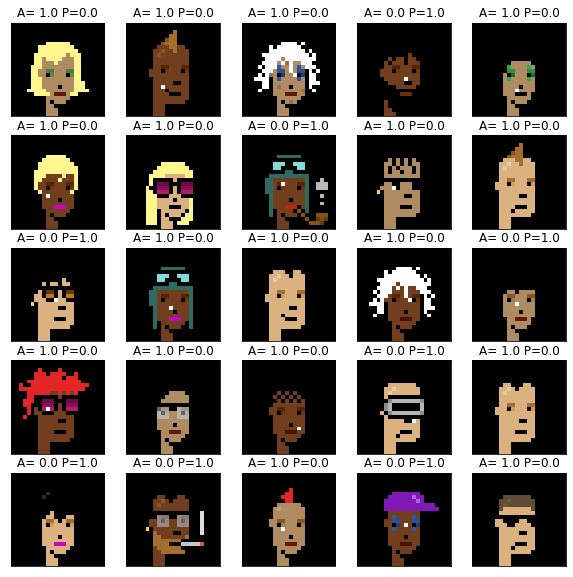

In [200]:
print('First 25 In Sample Errors')
j=0;
plt.figure(figsize=(10,10))
for i in range(in_l):
  if(in_y_label[i]!=y_train[i]):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train_new[j,:,:,:].astype('uint8'))
    plt.title('A= {0} P={1}'.format(y_train[i][0],in_y_label[i]))
    j=j+1
    if(j==25):
      break

First 25 Out Sample Errors


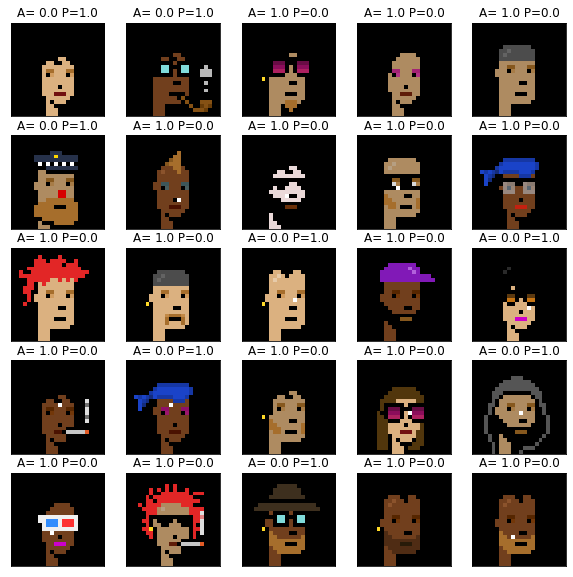

In [201]:
print('First 25 Out Sample Errors')
j=0;
plt.figure(figsize=(10,10))
for i in range(in_l):
  if(out_y_label[i]!=y_test[i]):
    plt.subplot(5,5,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test_new[j,:,:,:].astype('uint8'))
    plt.title('A= {0} P={1}'.format(y_test[i][0],out_y_label[i]))
    j=j+1
    if(j==25):
      break

In [186]:
def give_prob(inpt):
  arr=np.empty((2400,2400,3))
  for i in range(100):
    for j in range(100):
      a,b =24*i,24* (i+1)
      c,d =24*j,24* (j+1)
      idx=j+i *(100)
      arr[a:b,c:d,:]=inpt[idx,:,:,:]
      
  final = np.empty((10000, 3, 24, 24))
  for i in range(100):
    for j in range(100):
      a, b = 24 * i, 24 * (i + 1)  
      c, d = 24 * j, 24 * (j + 1) 
      idx = j + i * (100)
      final[idx,0,:,:] = arr[a:b,c:d,0]
      final[idx,1,:,:] = arr[a:b,c:d,1]
      final[idx,2,:,:] = arr[a:b,c:d,2]
  final=final[:,:,:,:]/255

  outp=net(torch.Tensor(final)).detach().numpy()
  return outp

In [187]:
yy=give_prob(cancerpunks)